<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelOneHotModCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 214 (delta 1), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (214/214), 22.28 MiB | 8.96 MiB/s, done.
Resolving deltas: 100% (91/91), done.
ldpc_ber_18_11.png  ldpc_ber_2_4.png  project  sample_data
EncoderModulatorSplitArch.ipynb  MainModelKerasOneHot.ipynb
EncoderOutputExperiment.ipynb	 MainModelModCoding.ipynb
End2End8PSK.ipynb		 MainModelOneHotMethod.ipynb
End2EndOneHotQPSK.ipynb		 MainModelOneHotMethodSoftMax.ipynb
End2EndQPSK.ipynb		 MainModelOneHotModCoding.ipynb
End2EndQPSKRegularized.ipynb	 MainModelWithSingleBERTraining.ipynb
MainModel.ipynb			 README.md
MainModelKeras.ipynb		 util.py


In [24]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [25]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [26]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [27]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 0 ... 0 1 0]
 [1 1 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 1 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [28]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.65s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.15s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.75s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.27s
SNR: 0.000:
 -> BER: 0.65
 -> Total Time: 15.83s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.30s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.62s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.88s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.18s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 12.98s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.07s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.13s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.13s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.23s
SNR: 1.000:
 -> BER: 0.49
 -> Total Time: 10.56s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.71s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [29]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.34s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.73s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.10s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.56s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 13.73s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.23s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.49s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.63s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.74s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 12.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.96s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.82s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.71s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.66s
SNR: 1.000:
 -> BER: 0.49
 -> Total Time: 9.15s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.81s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.50s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [30]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.43s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.82s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.27s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.74s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 14.27s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.23s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.41s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.59s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.81s
SNR: 0.500:
 -> BER: 0.56
 -> Total Time: 12.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.74s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.63s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.54s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 8.64s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.82s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.60s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

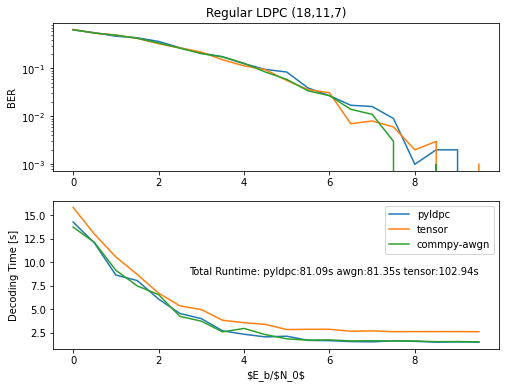

In [31]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [32]:
class GetOutOfLoop( Exception ):
    pass

In [33]:
# Define Model 
from keras.layers.normalization import BatchNormalization

# input_message_length is initialized by ldpc encoder
CHANEL_SIZE = 2
num_hidden_1 = CHANEL_SIZE
input_message_length = 4
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length, 2**input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  #layer_1 = BatchNormalization ()(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 4


In [34]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 16)
(1, 10000)


In [35]:
batch_size = 100

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 10
outer_ephocs = 1
display_step = 2
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
lr = 0.1
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (7)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.001
          elif(i < 200):
            lr = 0.0001
          else:
            lr = 0.00001 
          #lr = 0.00001
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

Streaming output truncated to the last 5000 lines.
Step 10022: Minibatch Loss: 2.331071
Step 10024: Minibatch Loss: 2.367362
Step 10026: Minibatch Loss: 2.427654
Step 10028: Minibatch Loss: 2.323734
Step 10030: Minibatch Loss: 2.372503
Step 10032: Minibatch Loss: 2.292210
Step 10034: Minibatch Loss: 2.310699
Step 10036: Minibatch Loss: 2.375527
Step 10038: Minibatch Loss: 2.285940
Step 10040: Minibatch Loss: 2.334267
Step 10042: Minibatch Loss: 2.302593
Step 10044: Minibatch Loss: 2.284627
Step 10046: Minibatch Loss: 2.380848
Step 10048: Minibatch Loss: 2.328434
Step 10050: Minibatch Loss: 2.408556
Step 10052: Minibatch Loss: 2.416823
Step 10054: Minibatch Loss: 2.358299
Step 10056: Minibatch Loss: 2.401217
Step 10058: Minibatch Loss: 2.320373
Step 10060: Minibatch Loss: 2.258119
Step 10062: Minibatch Loss: 2.435277
Step 10064: Minibatch Loss: 2.293122
Step 10066: Minibatch Loss: 2.394648
Step 10068: Minibatch Loss: 2.286168
Step 10070: Minibatch Loss: 2.373157
Step 10072: Minibatch Lo

In [44]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_x = []
channel_y = []
channel_n_x = []
channel_n_y = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message)
    channel_x.append(encoded_message[0])
    channel_y.append(encoded_message[1])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.49s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.75s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 0.000:
 -> BER: 0.84
 -> Total Time: 2.48s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.75s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 0.500:
 -> BER: 0.81
 -> Total Time: 2.52s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.49s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.74s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 1.000:
 -> BER: 0.81
 -> Total Time: 2.48s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.49s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

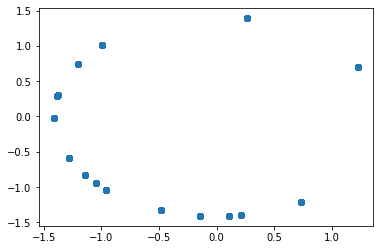

In [46]:
import matplotlib.pyplot as plt


plt.scatter(channel_x, channel_y)

plt.show()

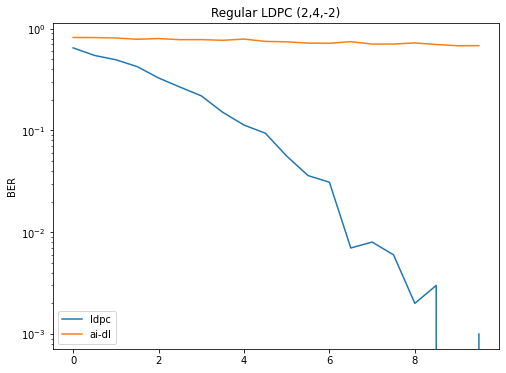

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [38]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(1000, 16)
(1, 1000)


In [39]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.48s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.73s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.98s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 2.42s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.48s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.73s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.99s
SNR: 0.500:
 -> BER: 0.82
 -> Total Time: 2.45s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.48s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.73s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.97s
SNR: 1.000:
 -> BER: 0.82
 -> Total Time: 2.41s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.48s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

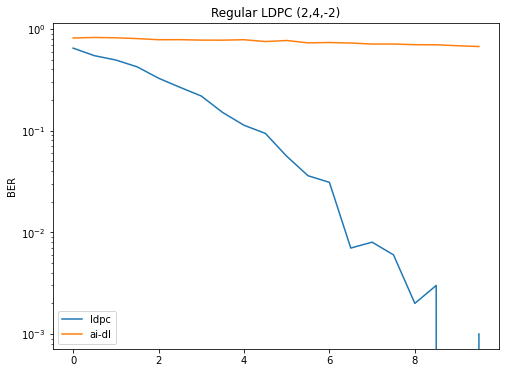

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()